In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150

In [2]:
area = "E02002559"

In [26]:
def process_df_by_age_sex(df):
    df = df.loc[df.index != "total"].copy()
    old_index = df.index
    new_index = [" ".join(name.split(" ")[:-1][::-1]) for name in df.index ]
    ethnicities = [name.split(" ")[-1] for name in df.index]
    df["age_sex"] = new_index
    df["attribute"] = ethnicities
    df = df.set_index("age_sex")
    df = df.rename(columns={area: "counts"})
    return df

In [27]:
sex_by_age = pd.read_csv("./Census_2011_MSOA/crosstables/sex_by_age_5yrs.csv", index_col=0).loc[area].to_frame()
ethn_by_age_sex = process_df_by_age_sex(pd.read_csv("./Census_2011_MSOA/crosstables/ethnic_by_sex_by_age.csv", index_col=0).loc[area].to_frame())
marital_by_age_sex = process_df_by_age_sex(pd.read_csv("./Census_2011_MSOA/crosstables/marital_by_sex_by_age.csv", index_col=0).loc[area].to_frame())
religion_by_age_sex = process_df_by_age_sex(pd.read_csv("./Census_2011_MSOA/crosstables/religion_by_sex_by_age.csv", index_col=0).loc[area].to_frame())

In [28]:
n_individuals = sex_by_age.loc["total"].values[0]
n_individuals

8842

In [29]:
ethn_by_age_sex

,counts,attribute
age_sex,,
0-4 M,274,W0
0-4 M,0,W1
0-4 M,1,W2
0-4 M,3,W3
0-4 M,0,M0
...,...,...
85+ F,0,B0
85+ F,0,B1
85+ F,0,B2


In [30]:
def get_age_and_sexes(df):
    ages = []
    sexes = []
    for name, value in df.iterrows():
        value = value.values[0]
        if name == "total":
            continue
        age, sex = name.split(" ")
        ages += [age] * value
        sexes += [sex] * value
    return np.array(ages), np.array(sexes)

def get_attribute(df, attribute_df):
    attributes = []
    for label in np.unique(df.index):
        n_individuals = len(df.loc[label])
        if label not in attribute_df.index:
            attributes += ["None"] * n_individuals
            continue
            
        n_attributes = attribute_df.loc[label]["counts"].sum()
        assert n_individuals == n_attributes
        
        counts_list = attribute_df.loc[label, "counts"].values
        attributes_list = attribute_df.loc[label, "attribute"].values
        for (counts, attribute) in zip(counts_list, attributes_list):
            attributes += [attribute] * counts
    return np.array(attributes)

In [31]:
ages, sexes = get_age_and_sexes(sex_by_age)

In [32]:
df = pd.DataFrame()
df["age"] = ages
df["sex"] = sexes
age_sex_labels  = [f"{age} {sex}" for (age, sex) in zip(ages,sexes)]
df.index = age_sex_labels
df["ethnicity"] = get_attribute(df, ethn_by_age_sex)
df["marital_status"] = get_attribute(df, marital_by_age_sex)
df["religion"] = get_attribute(df, religion_by_age_sex)

In [33]:
df.head()

,age,sex,ethnicity,marital_status,religion
0-4 M,0-4,M,W0,None,C
0-4 M,0-4,M,W0,None,C
0-4 M,0-4,M,W0,None,C
0-4 M,0-4,M,W0,None,C
0-4 M,0-4,M,W0,None,C


# Cross-check with data

<Axes: xlabel='labels'>

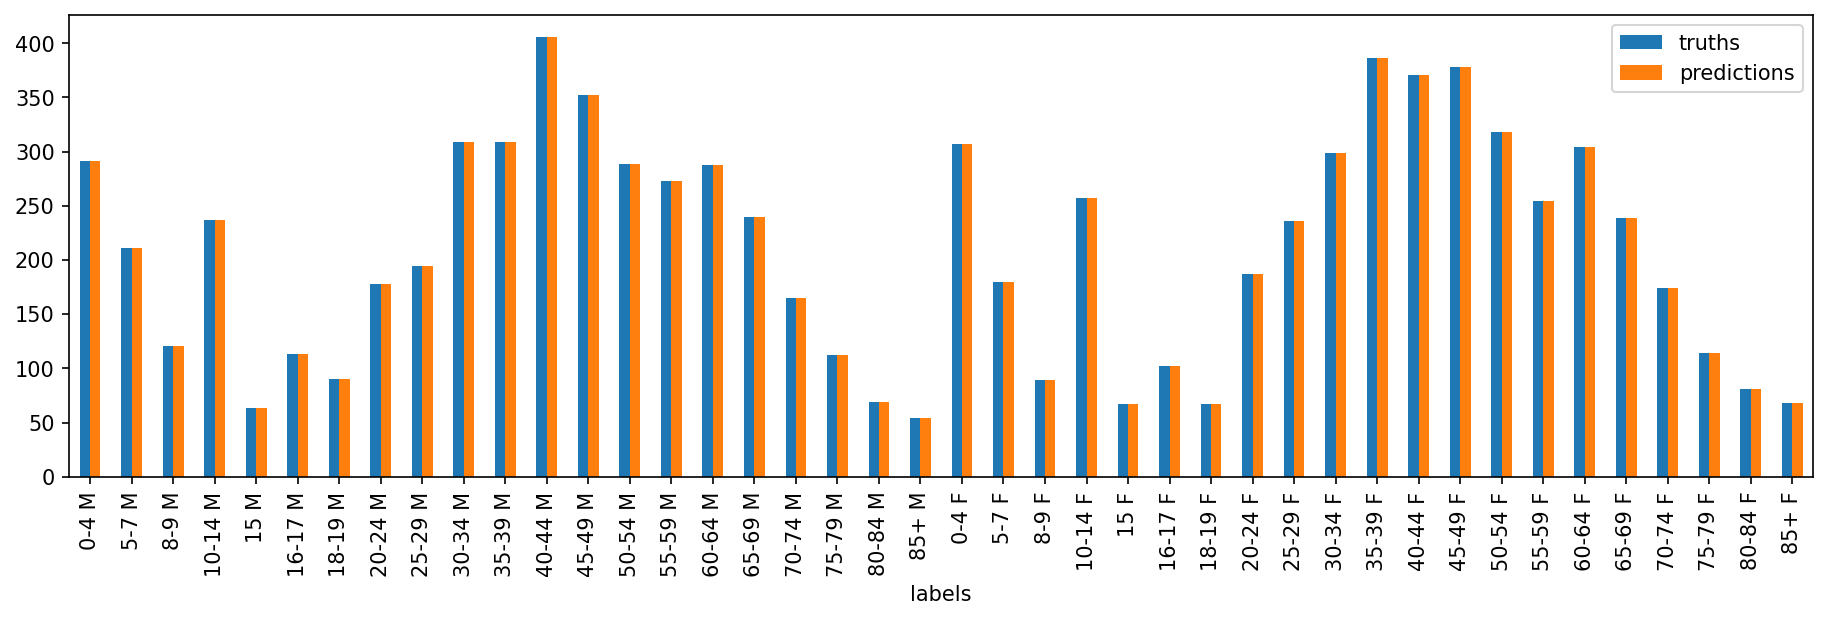

In [35]:
# Age and Sex
labels = []
predictions = []
truths = []
for label in sex_by_age.index:
    if label == "total":
        continue
    pred_counts = len(df.loc[label])
    labels.append(label)
    predictions.append(pred_counts)
    truths.append(sex_by_age.loc[label].values[0])

df_plot = pd.DataFrame()
df_plot["truths"] = truths
df_plot["predictions"] = predictions
df_plot["labels"] = labels
df_plot.set_index("labels", inplace=True)
df_plot.plot.bar(figsize=(15, 4))

In [36]:
def get_df_ratio(df, df_attribute, attribute_name):
    labels_to_save = []
    attributes_to_save = []
    ratios = []
    for label in df.index:
        if label not in df_attribute.index:
            continue
        counts_list = df_attribute.loc[label]["counts"]
        attributes_list = df_attribute.loc[label]["attribute"]
        individuals = df.loc[label]
        individual_attributes = individuals.groupby(attribute_name).count()["age"]
        for counts, attribute in zip(counts_list, attributes_list):
            if attribute not in individual_attributes.index:
                ratio = 1
            else:
                individual_counts = individual_attributes.loc[attribute]
                if counts == 0:
                    #assert individual_counts == 0
                    ratio = 1
                else:
                    ratio = individual_counts / counts
            labels_to_save.append(label)
            attributes_to_save.append(attribute)
            ratios.append(ratio)
    ret = pd.DataFrame()
    ret["ratio"] = ratios
    ret["label"] = labels_to_save
    ret["attributes"] = attributes_to_save
    return ret

In [37]:
ethn_plot_df = get_df_ratio(df, ethn_by_age_sex, "ethnicity")

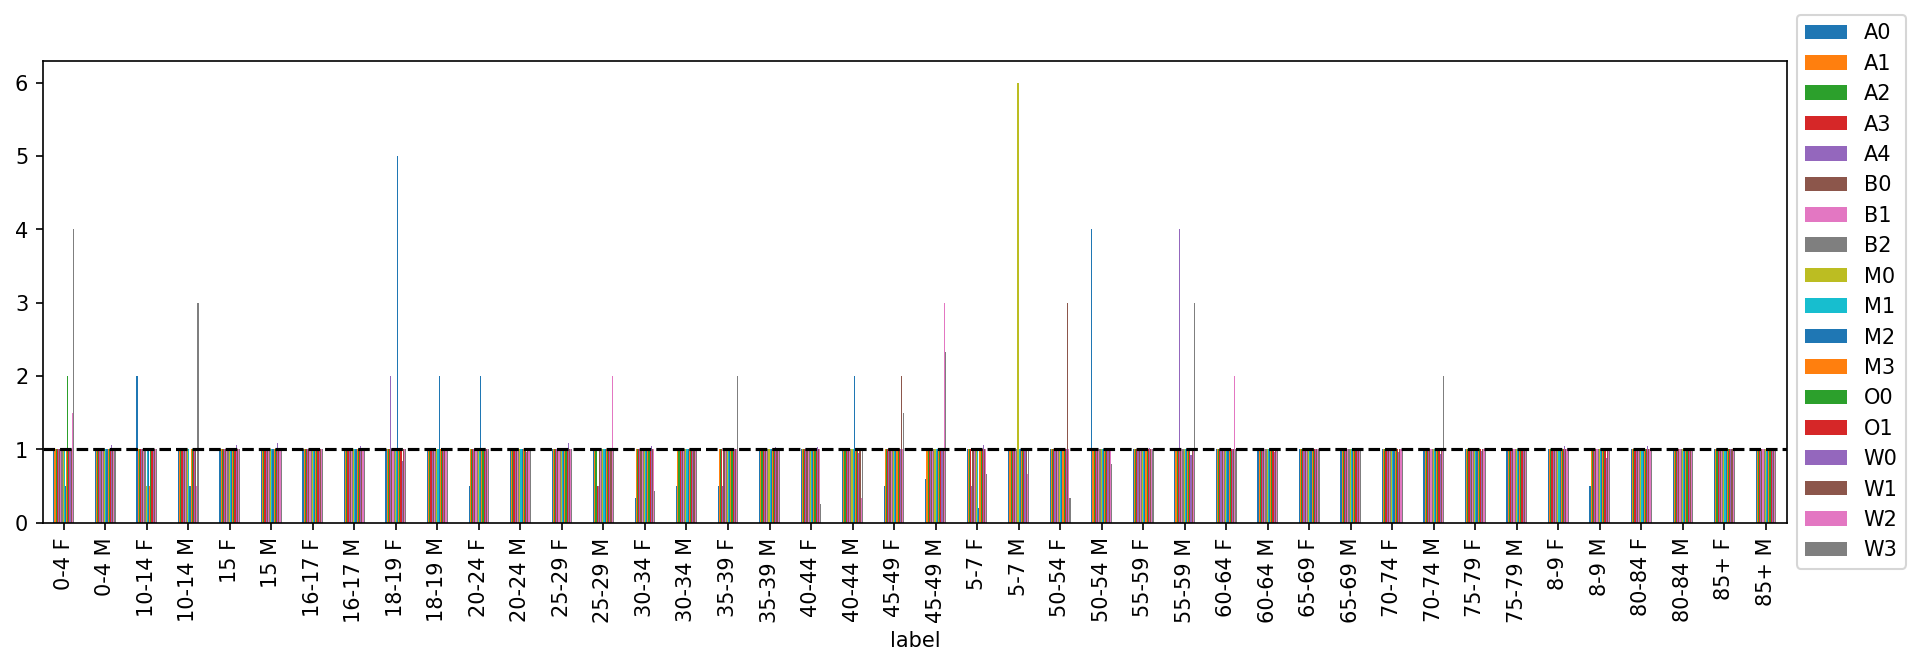

In [38]:
f, ax = plt.subplots(figsize=(15, 4))
ethn_plot_df.pivot_table(index="label", columns="attributes")["ratio"].plot.bar(ax=ax)
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
ax.axhline(1, color = "black", linestyle="--")

In [39]:
marital_plot_df = get_df_ratio(df, marital_by_age_sex, "marital_status")

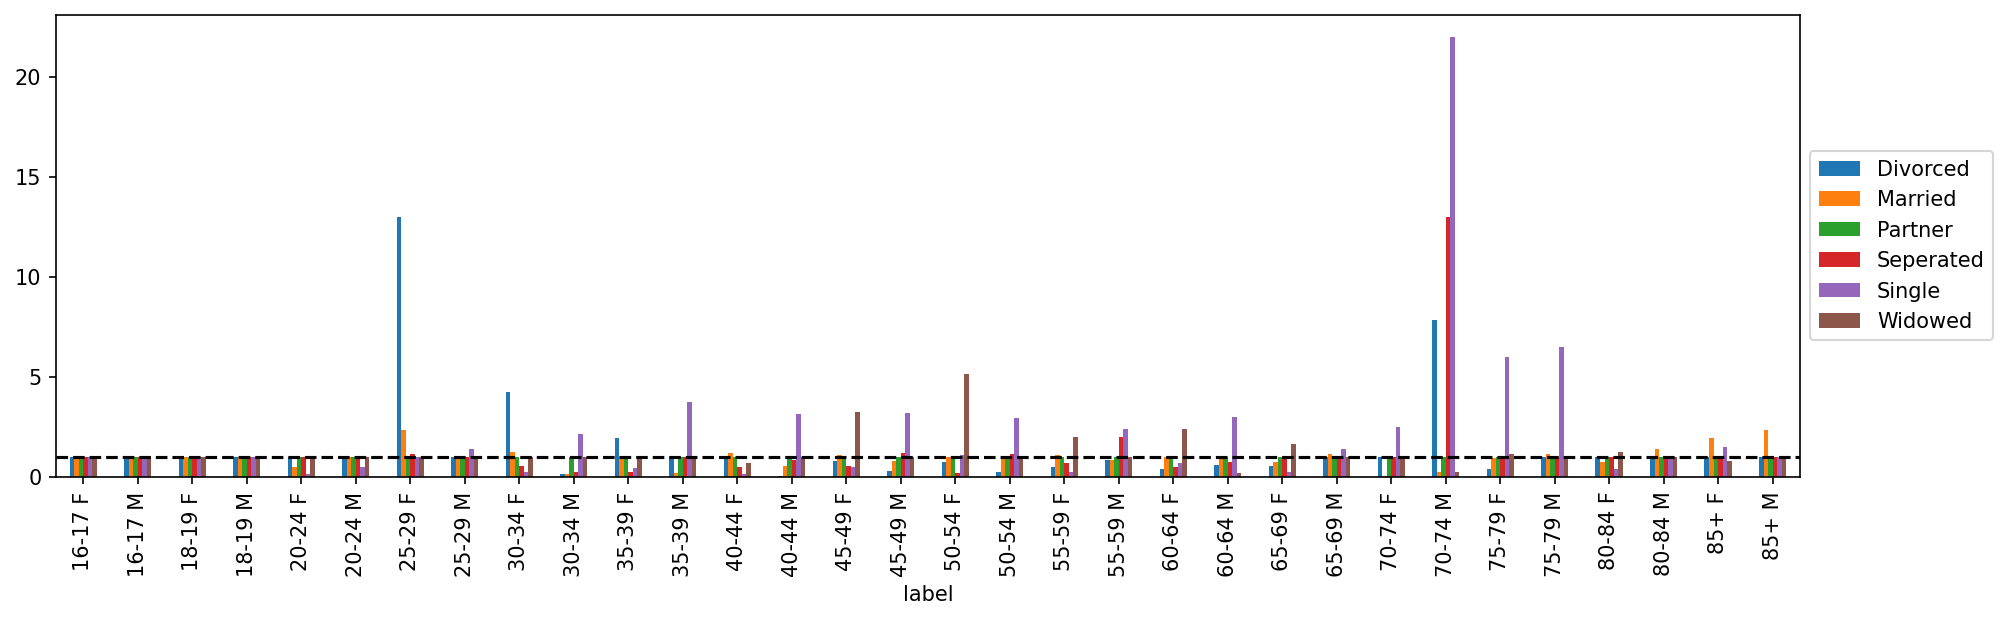

In [40]:
f, ax = plt.subplots(figsize=(15, 4))
marital_plot_df.pivot_table(index="label", columns="attributes")["ratio"].plot.bar(ax=ax)
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
ax.axhline(1, color = "black", linestyle="--")

In [41]:
religion_plot_df = get_df_ratio(df, religion_by_age_sex, "religion")

(0.5, 4.0)

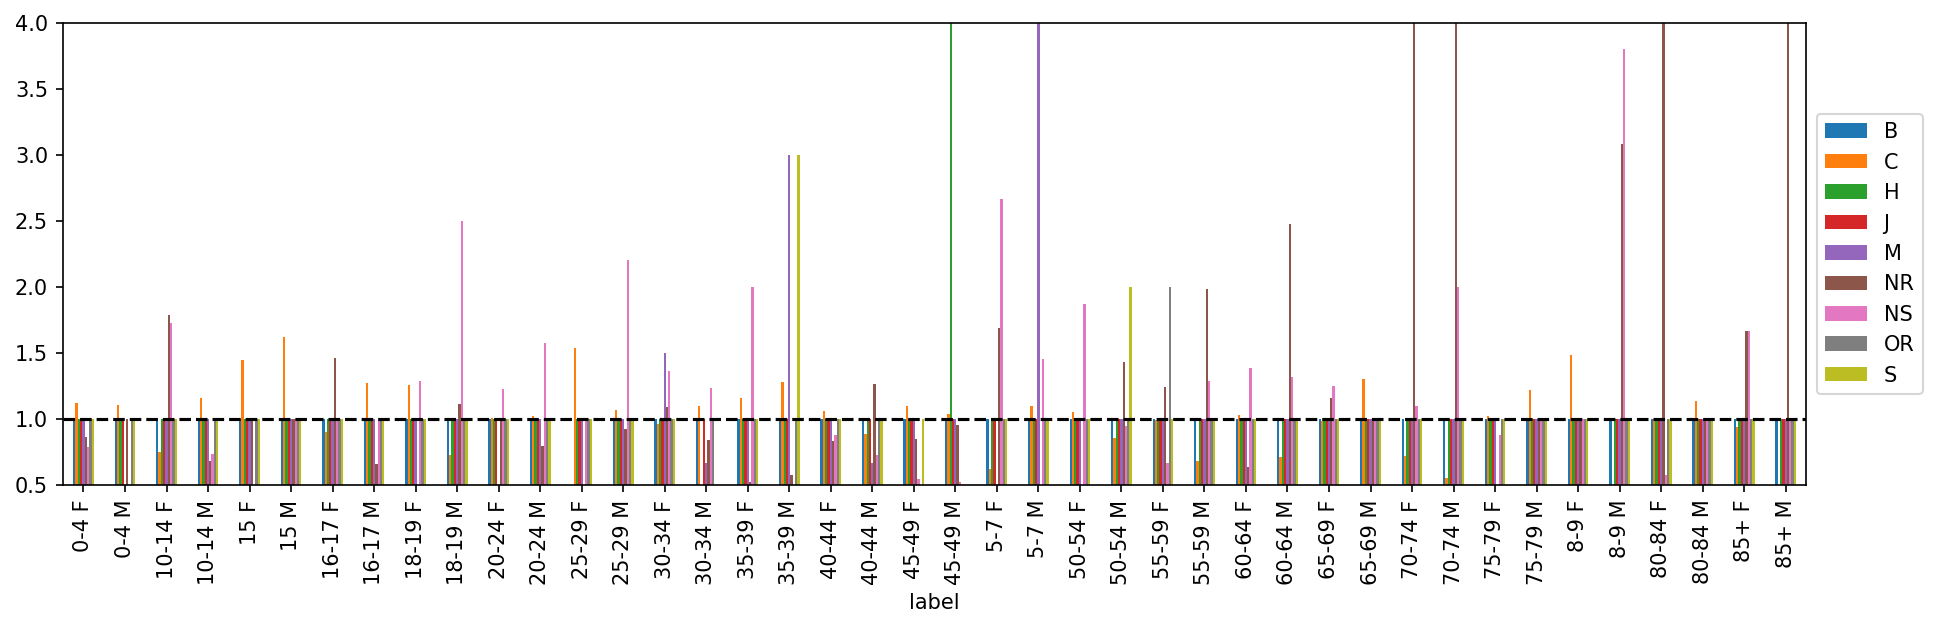

In [42]:
f, ax = plt.subplots(figsize=(15, 4))
religion_plot_df.pivot_table(index="label", columns="attributes")["ratio"].plot.bar(ax=ax)
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
ax.axhline(1, color = "black", linestyle="--")
ax.set_ylim(0.5, 4)